# Hyperparameters and lags search: backtesting vs one-step-ahead

Hyperparameter and lag tuning involves systematically testing different values or combinations of hyperparameters (and/or lags) to find the optimal configuration that gives the best performance. The **skforecast** library provides two different methods to evaluate each candidate configuration:

+ Backtesting: In this method, the model predicts several steps ahead in each iteration, using the same forecast horizon and retraining frequency strategy that would be used if the model were deployed. This simulates a real forecasting scenario where the model is retrained and updated over time.

+ One-Step Ahead: Evaluates the model using only one-step-ahead predictions. This method is faster because it requires fewer iterations, but it only tests the model's performance in the immediate next time step.

Each method uses a different evaluation strategy, so they may produce different results. However, in the long run, both methods are expected to converge to similar selections of optimal hyperparameters. The one-step-ahead method is much faster than backtesting because it requires fewer iterations, but it only tests the model's performance in the immediate next time step. It is recommended to backtest the final model for a more accurate multi-step performance estimate.

This document compares the results of each approach when applied to different forecasters and datasets. To do this, the skforecast functions `grid_search_forecaster`, `bayesian_search_forecaster`, `grid_search_forecaster_multiseries` and `bayesian_search_forecaster_multiseries` are used to search for the optimal hyperparameters and lags for each forecaster using the backtesting and one-step-ahead methods, respectively. The search is performed on the validation dataset, and the best configuration is then backtested on the test dataset. The time required to perform the search for each method is recorded, as is the performance of the best configuration found.

## Results

<div style="text-align: center;">
    <img src="grid_search_results.png" alt="Grid Search Results" width="700"/>
</div>

<div style="text-align: center;">
    <img src="bayesian_search_results.png" alt="Grid Search Results" width="700"/>
</div>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The purpose of this analysis is to compare the time and prediction performance of the two available methods, not to compare different forecasters.

</div>

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent.parent)
print(path)
sys.path.insert(1, path)

'/home/ubuntu/varios/skforecast'

## Libraries

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from copy import copy
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries

# Warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Data sets

In [3]:
data_bike = fetch_dataset('bike_sharing_extended_features', verbose=False)
data_sales = fetch_dataset(name="items_sales", verbose=False)
data_sales = data_sales * 100

data_website = fetch_dataset(name="website_visits", raw=True, verbose=False)
data_website['date'] = pd.to_datetime(data_website['date'], format='%d/%m/%y')
data_website = data_website.set_index('date')
data_website = data_website.asfreq('1D')
data_website = data_website.sort_index()
data_website['month'] = data_website.index.month
data_website['month_day'] = data_website.index.day
data_website['week_day'] = data_website.index.day_of_week
data_website = pd.get_dummies(data_website, columns=['month', 'week_day', 'month_day'], dtype='int64')

data_electricity = fetch_dataset(name='vic_electricity', raw=False, verbose=False)
data_electricity = data_electricity.drop(columns="Date")
data_electricity = (
    data_electricity
    .resample(rule="h", closed="left", label="right")
    .agg({
        "Demand": "mean",
        "Temperature": "mean",
        "Holiday": "mean",
    })
)
data_electricity = data_electricity.loc['2012-01-01 00:00:00': '2013-12-30 23:00:00'].copy()

In [4]:
data_sales * 100

,item_1,item_2,item_3
date,,,
2012-01-01,82531.745918,210477.272727,194297.394638
2012-01-02,227778.257304,265781.250000,280098.630804
2012-01-03,275490.988882,317510.416667,320789.220997
2012-01-04,258955.329422,245677.083333,272522.755799
2012-01-05,213792.376946,181916.666667,203577.367810
...,...,...,...
2014-12-28,173292.325672,181895.833333,205860.298927
2014-12-29,196116.228892,245395.833333,281273.899844
2014-12-30,188570.258296,176770.833333,215557.815929


## Benchmark

In [5]:
# Functions to compare results using backtesting and one step ahead
# ==============================================================================
def run_benchmark(
    data,
    forecaster_to_benchmark,
    search_method = None,
    lags_grid = None,
    param_grid = None,
    search_space = None,
    end_train = None,
    end_validation = None,
    target = None,
    exog_features = None,
    steps = None,
    metric = None
):
    """
    Compare results of grid search and bayesian search using backtesting and one-step-ahead.
    """
    
    # backtesting
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_1 = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        return_best        = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = False
                    )
    else:
        results_1, _ = bayesian_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        search_space       = search_space,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = False
                    )

    end = time()
    time_1 = end - start
    best_params = results_1.loc[0, 'params']
    best_lags = results_1.loc[0, 'lags']
    forecaster.set_params(best_params)
    forecaster.set_lags(lags=best_lags)
    metric_1, pred_1 = backtesting_forecaster(
                        forecaster          = forecaster,
                        y                   = data.loc[:, target],
                        exog                = data.loc[:, exog_features] if exog_features else None,
                        initial_train_size  = len(data.loc[:end_validation]),
                        steps               = steps,
                        metric              = metric,
                        verbose             = False,
                        show_progress       = False
                        )

    # One step ahead
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_2 = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        return_best        = False,
                        verbose            = False,
                        show_progress      = False
                    )
    else:
        results_2, _ = bayesian_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        steps              = steps,
                        search_space       = search_space,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = False,
                        verbose            = False,
                        show_progress      = False
                    )

    end = time()
    time_2 = end - start
    best_params = results_2.loc[0, 'params']
    best_lags = results_2.loc[0, 'lags']
    forecaster.set_params(best_params)
    forecaster.set_lags(lags=best_lags)
    metric_2, pred_2 = backtesting_forecaster(
                        forecaster          = forecaster,
                        y                   = data.loc[:, target],
                        exog                = data.loc[:, exog_features] if exog_features else None,
                        initial_train_size  = len(data.loc[:end_validation]),
                        steps               = steps,
                        metric              = metric,
                        verbose             = False,
                        show_progress       = False
                        )

    print("-----------------")
    print("Benchmark results")
    print("-----------------")
    print('Execution time backtesting   :', time_1)
    print('Execution time one step ahead:', time_2)
    print(f"Same lags  : {np.array_equal(results_1.loc[0, 'lags'], results_2.loc[0, 'lags'])}")
    print(f"Same params: {results_1.loc[0, 'params'] == results_2.loc[0, 'params']}")
    print("")
    print("Method: backtesting")
    print(f"    lags   : {results_1.loc[0, 'lags']}")
    print(f"    params : {results_1.loc[0, 'params']}")
    print(f"    {metric}: {metric_1.loc[0, metric]}")
    print("")
    print("Method: one step ahead")
    print(f"    lags   : {results_2.loc[0, 'lags']}")
    print(f"    params : {results_2.loc[0, 'params']}")
    print(f"    {metric}: {metric_2.loc[0, metric]}")
    
    return time_1, time_2, metric_1.loc[0, metric], metric_2.loc[0, metric]


# Functions to compare results using backtesting and one step ahead
# ==============================================================================
def run_benchmark_multiseries(
    data = None,
    forecaster_to_benchmark = None,
    search_method = None,
    lags_grid = None,
    param_grid = None,
    search_space = None,
    end_train = None,
    end_validation = None,
    levels = None,
    exog_features = None,
    steps = None,
    metric = None
):
    """
    Compare results of grid search using backtesting and one-step-ahead.
    """
    
    # Backtesting
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_1 = grid_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        levels             = levels,
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        return_best        = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = False
                    )
    else:
        results_1, _ = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        levels             = levels,
                        search_space       = search_space,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = False
                    )
    end = time()
    time_1 = end - start
    best_params = results_1.loc[0, 'params']
    best_lags = results_1.loc[0, 'lags']
    forecaster.set_params(best_params)
    forecaster.set_lags(lags=best_lags)
    metric_1, pred_1 = backtesting_forecaster_multiseries(
                            forecaster          = forecaster,
                            series              = data.loc[:, levels],
                            exog                = data.loc[:, exog_features] if exog_features else None,
                            initial_train_size  = len(data.loc[:end_validation]),
                            levels              = levels,
                            steps               = steps,
                            metric              = metric,
                            verbose             = False,
                            show_progress       = False
                        )

    # One step ahead
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_2 = grid_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        levels             = levels,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        return_best        = False,
                        verbose            = False,
                        show_progress      = False
                    )
    else:
        results_2, _ = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        levels             = levels,
                        steps              = steps,
                        search_space       = search_space,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = False,
                        verbose            = False,
                        show_progress      = False
                    )

    end = time()
    time_2 = end - start
    best_params = results_2.loc[0, 'params']
    best_lags = results_2.loc[0, 'lags']
    forecaster.set_params(best_params)
    forecaster.set_lags(lags=best_lags)
    metric_2, pred_2 = backtesting_forecaster_multiseries(
                            forecaster          = forecaster,
                            series              = data.loc[:, levels],
                            exog                = data.loc[:, exog_features] if exog_features else None,
                            levels              = levels,
                            initial_train_size  = len(data.loc[:end_validation]),
                            steps               = steps,
                            metric              = metric,
                            verbose             = False,
                            show_progress       = False
                        )

    print("Benchmark results")
    print("-----------------")
    print('Execution time backtesting   :', time_1)
    print('Execution time one step ahead:', time_2)
    print(f"Same lags  : {np.array_equal(results_1.loc[0, 'lags'], results_2.loc[0, 'lags'])}")
    print(f"Same params: {results_1.loc[0, 'params'] == results_2.loc[0, 'params']}")
    print("")
    print("Method: backtesting")
    print(f"    lags   : {results_1.loc[0, 'lags']}")
    print(f"    params : {results_1.loc[0, 'params']}")
    print(f"    {metric_1.loc[0, metric]}")
    print("")
    print("Method: one step ahead")
    print(f"    lags   : {results_2.loc[0, 'lags']}")
    print(f"    params : {results_2.loc[0, 'params']}")
    print(f"    {metric_2.loc[0, metric]}")
    
    return time_1, time_2, metric_1.loc[0, metric], metric_2.loc[0, metric]


def summarize_results(results, metric, plot=True, save_plot=None, fig_size=(8, 4)):
    """
    Summarize results of benchmark.
    """

    results = pd.DataFrame(
        results,
        columns=[
            "dataset",
            "forecaster",
            "time_search_backtesting",
            "time_search_one_step",
            "metric_backtesting",
            "metric_one_step",
        ]
    )
    results['speed_up'] = (
        results['time_search_backtesting'] / results['time_search_one_step']
    ).round(2)
    results["dataset_forecaster"] = (
        results["dataset"]
        + " \n "
        + results["forecaster"].str.replace("Forecaster", "")
    )
    display(results)

    if plot:
        set_dark_theme()
        fig, axs = plt.subplots(2, 1, figsize=fig_size, sharex=True)
        results.plot.bar(
            x='dataset_forecaster',
            y=['time_search_backtesting', 'time_search_one_step'],
            ax=axs[0],
        )
        axs[0].set_ylabel('time (s)')
        axs[0].legend(["backtesting", "one-step-ahead"])
        results.plot.bar(
            x='dataset_forecaster',
            y=['metric_backtesting', 'metric_one_step'],
            ax=axs[1],
            legend=False
        )
        axs[1].set_ylabel(f'{metric}')
        axs[1].set_xlabel('')
        plt.xticks(rotation=90)
        plt.suptitle('Grid search using backtesting vs one-step-ahead')
        plt.tight_layout()

        if save_plot:
            plt.savefig(save_plot, dpi=300, bbox_inches='tight')

### Grid search

In [6]:
# Results
# ==============================================================================
results_grid_search = []
metric = 'mean_absolute_error'

In [7]:
# Dataset bike_sharing_extended_features - ForecasterAutoreg
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
exog_features = [
    'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'week_day_sin',
    'week_day_cos', 'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos',
    'sunset_hour_sin', 'sunset_hour_cos', 'holiday_previous_day', 'holiday_next_day',
    'temp_roll_mean_1_day', 'temp_roll_mean_7_day', 'temp_roll_max_1_day',
    'temp_roll_min_1_day', 'temp_roll_max_7_day', 'temp_roll_min_7_day',
    'temp', 'holiday'
]

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)

results_grid_search.append([
    'bike',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 74.94016456604004
Execution time one step ahead: 7.218931674957275
Same lags  : False
Same params: True

Method: backtesting
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
    mean_absolute_error: 58.276762590192014

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
    mean_absolute_error: 64.04254202108999


In [8]:
# Dataset bike_sharing_extended_features - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 steps         = 24,
                 lags          = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {'alpha': np.logspace(-3, 3, 20)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'bike',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 86.17308926582336
Execution time one step ahead: 1.4048247337341309
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 112.88378916846884}
    mean_absolute_error: 79.14111581771634

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'alpha': 6.158482110660261}
    mean_absolute_error: 111.93473570444289


In [9]:
# Dataset website_visits - ForecasterAutoreg
# ==============================================================================
end_train = '2021-03-30 23:59:00'
end_validation = '2021-06-30 23:59:00'
exog_features = [col for col in data_website.columns if col.startswith(('month_', 'week_day_', 'month_day_'))]

forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

param_grid = {'alpha': np.logspace(-3, 3, 20)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7,
    metric                  = metric
)
results_grid_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 7.856830358505249
Execution time one step ahead: 0.4346332550048828
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 6.158482110660261}
    mean_absolute_error: 162.11396980738706

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 2.976351441631316}
    mean_absolute_error: 162.3516346601722


In [10]:
# Dataset website_visits - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor = Ridge(random_state=123),
                 steps     = 24,
                 lags      = 10
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

param_grid = {'alpha': np.logspace(-3, 3, 20)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 9.812748670578003
Execution time one step ahead: 0.818958044052124
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 6.158482110660261}
    mean_absolute_error: 277.8362513175169

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 0.6951927961775606}
    mean_absolute_error: 226.98505311911217


In [11]:
# Dataset vic_electricity - ForecasterAutoreg
# ==============================================================================
end_train = '2013-06-30 23:59:00'
end_validation = '2013-11-30 23:59:00'
exog_features = ['Temperature', 'Holiday']

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 73.72903800010681
Execution time one step ahead: 6.305500745773315
Same lags  : False
Same params: True

Method: backtesting
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
    mean_absolute_error: 194.83553235066182

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
    mean_absolute_error: 188.8782299908785


In [12]:
# Dataset vic_electricity - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 steps         = 24,
                 lags          = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {'alpha': np.logspace(-3, 3, 20)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 79.82872295379639
Execution time one step ahead: 1.088252305984497
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 6.158482110660261}
    mean_absolute_error: 304.22332781257694

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 1.438449888287663}
    mean_absolute_error: 301.7070971763055


In [13]:
# Dataset sales - ForecasterAutoregMultiSeries
# ==============================================================================
end_train = '2014-05-15 23:59:00'
end_validation = '2014-07-15 23:59:00'
levels = ['item_1', 'item_2', 'item_3']
exog_features = None 

forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = "ordinal",
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = {
    '24 lags': 24,
    '48 lags': 48
}

param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [3, 7]
}

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 36,
    metric                  = metric
)
results_grid_search.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

Benchmark results
-----------------
Execution time backtesting   : 2.0305566787719727
Execution time one step ahead: 0.8541133403778076
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
    params : {'max_depth': 7, 'n_estimators': 50}
    137.2464535825166

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'max_depth': 3, 'n_estimators': 50}
    144.36649079083782


In [14]:
# Dataset sales - ForecasterAutoregMultiVariate
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 steps              = 5,
                 level              = 'item_1',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = {
    '24 lags': 24,
    '48 lags': 48
}

param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [3, 7]
}

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 5,
    metric                  = metric
)

results_grid_search.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

Benchmark results
-----------------
Execution time backtesting   : 6.2137532234191895
Execution time one step ahead: 1.1533012390136719
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'max_depth': 3, 'n_estimators': 50}
    102.79155859234993

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'max_depth': 7, 'n_estimators': 200}
    105.28978251430038


,dataset,forecaster,time_search_backtesting,time_search_one_step,metric_backtesting,metric_one_step,speed_up,dataset_forecaster
0,bike,ForecasterAutoreg,74.940165,7.218932,58.276763,64.042542,10.38,bike \n Autoreg
1,bike,ForecasterAutoregDirect,86.173089,1.404825,79.141116,111.934736,61.34,bike \n AutoregDirect
2,website,ForecasterAutoreg,7.856830,0.434633,162.113970,162.351635,18.08,website \n Autoreg
3,website,ForecasterAutoregDirect,9.812749,0.818958,277.836251,226.985053,11.98,website \n AutoregDirect
4,electricity,ForecasterAutoreg,73.729038,6.305501,194.835532,188.878230,11.69,electricity \n Autoreg
5,electricity,ForecasterAutoregDirect,79.828723,1.088252,304.223328,301.707097,73.35,electricity \n AutoregDirect
6,sales,ForecasterAutoregMultiSeries,2.030557,0.854113,137.246454,144.366491,2.38,sales \n AutoregMultiSeries
7,sales,ForecasterAutoregMultiVariate,6.213753,1.153301,102.791559,105.289783,5.39,sales \n AutoregMultiVariate


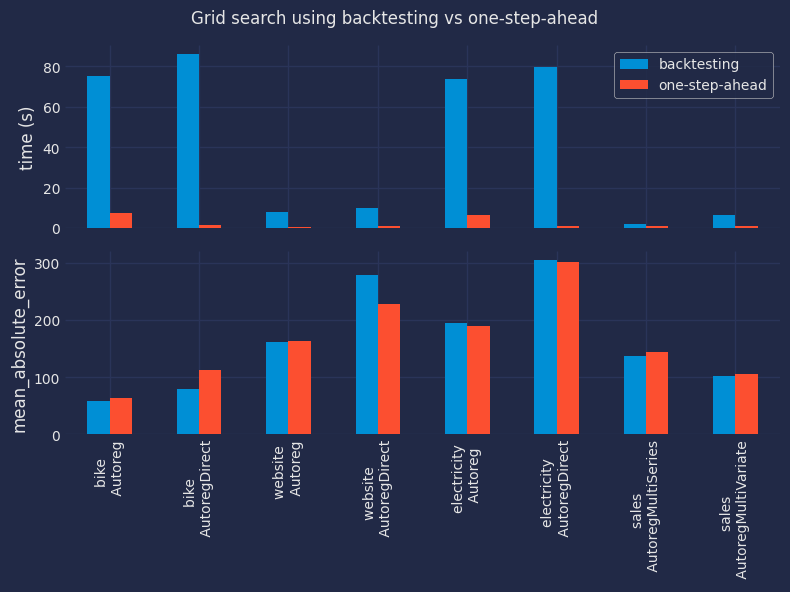

In [15]:
# Results
# ==============================================================================
summarize_results(
    results   = results_grid_search,
    metric    = metric,
    plot      = True,
    fig_size  = (8, 6),
    save_plot = "grid_search_results.png"
)

### Bayesian search

In [16]:
# Table to store results
# ==============================================================================
results_bayesian_search = []
metric = 'mean_absolute_error'

In [17]:
# Dataset bike_sharing_extended_features - ForecasterAutoreg
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
exog_features = [
    'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'week_day_sin',
    'week_day_cos', 'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos',
    'sunset_hour_sin', 'sunset_hour_cos', 'holiday_previous_day', 'holiday_next_day',
    'temp_roll_mean_1_day', 'temp_roll_mean_7_day', 'temp_roll_max_1_day',
    'temp_roll_min_1_day', 'temp_roll_max_7_day', 'temp_roll_min_7_day',
    'temp', 'holiday'
]

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_bayesian_search.append([
    'bike_sharing',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1703: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 75.35594654083252
Execution time one step ahead: 28.534313917160034
Same lags  : True
Same params: True

Method: backtesting
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.017833474222028703, 'gamma': 0.2285821738161964, 'reg_alpha': 0.2379772800670556, 'reg_lambda': 0.9887301767538853}
    mean_absolute_error: 55.80577702511616

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.017833474222028703, 'gamma': 0.2285821738161964, 'reg_alpha': 0.2379772800670556, 'reg_lambda': 0.9887301767538853}
    mean_absolute_error: 55.80577702511616


In [18]:
# Dataset bike_sharing_extended_features - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 steps         = 24,
                 lags          = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_bayesian_search.append([
    'bike_sharing',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1703: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 22.35158610343933
Execution time one step ahead: 1.3083136081695557
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 121.0898788312409}
    mean_absolute_error: 79.1498337214025

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'alpha': 4.884604686100813}
    mean_absolute_error: 111.92945191603201


In [19]:
# Dataset website_visits - ForecasterAutoreg
# ==============================================================================
end_train = '2021-03-30 23:59:00'
end_validation = '2021-06-30 23:59:00'
exog_features = [col for col in data_website.columns if col.startswith(('month_', 'week_day_', 'month_day_'))]

forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7,
    metric                  = metric
)

results_bayesian_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1703: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 1.559525489807129
Execution time one step ahead: 0.24279451370239258
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
    params : {'alpha': 0.07474245141964296}
    mean_absolute_error: 136.76802274106467

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 0.03182234592129467}
    mean_absolute_error: 173.5282998809151


In [20]:
# Dataset website_visits - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10,
                 steps         = 7
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7,
    metric                  = metric
)

results_bayesian_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1703: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 1.972360372543335
Execution time one step ahead: 0.29323554039001465
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
    params : {'alpha': 0.07474245141964296}
    mean_absolute_error: 139.40123604696382

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 0.03182234592129467}
    mean_absolute_error: 153.6723680506666


In [21]:
# Dataset vic_electricity - ForecasterAutoreg
# ==============================================================================
end_train = '2013-06-30 23:59:00'
end_validation = '2013-11-30 23:59:00'
exog_features = ['Temperature', 'Holiday']

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_bayesian_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1703: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 85.09476375579834
Execution time one step ahead: 24.986984491348267
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'n_estimators': 1200, 'max_depth': 8, 'learning_rate': 0.020288327487155415, 'gamma': 0.9893221948178936, 'reg_alpha': 0.0026751307734329544, 'reg_lambda': 0.0033431281459104997}
    mean_absolute_error: 196.74829952595292

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.056896300053531614, 'gamma': 0.2725691628660212, 'reg_alpha': 0.24605588251006993, 'reg_lambda': 0.9687485406819449}
    mean_absolute_error: 191.37491441780287


In [22]:
# Dataset vic_electricity - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10,
                 steps         = 24
             )

lags_grid = (48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169))

def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_bayesian_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1703: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 20.62668776512146
Execution time one step ahead: 0.6775445938110352
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 16.432489069228232}
    mean_absolute_error: 307.13365278620506

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 0.36149961722510493}
    mean_absolute_error: 300.87028133154746


In [23]:
# Dataset sales - ForecasterAutoregMultiSeries
# ==============================================================================
end_train = '2014-05-15 23:59:00'
end_validation = '2014-07-15 23:59:00'
levels = ['item_1', 'item_2', 'item_3']
exog_features = None 

forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = "ordinal",
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = [48, 72]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 50, 200),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 36,
    metric                  = metric
)
results_bayesian_search.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:2279: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


Benchmark results
-----------------
Execution time backtesting   : 4.79258394241333
Execution time one step ahead: 2.5300941467285156
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 74, 'max_depth': 8, 'learning_rate': 0.40420227800022523}
    187.83389755674088

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 198, 'max_depth': 3, 'learning_rate': 0.06045266837878549}
    133.65427971719967


In [24]:
# Dataset sales - ForecasterAutoregMultiVariate
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 steps              = 5,
                 level              = 'item_1',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = [48, 72]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 50, 200),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 5,
    metric                  = metric
)
results_bayesian_search.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:83: IgnoredArgumentWarning: `levels` argument have no use when the forecaster is of type `ForecasterAutoregMultiVariate`. The level of this forecaster is 'item_1', to predict another level, change the `level` argument when initializing the forecaster. 
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:83: IgnoredArgumentWarning: `levels` argument have no use when the forecaster is of type `ForecasterAutoregMultiVariate`. The level of this forecaster is 'item_1', to predict another level, change the `level` argument when initializing the forecaster. 
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/model_

Benchmark results
-----------------
Execution time backtesting   : 18.32214117050171
Execution time one step ahead: 5.379238843917847
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 178, 'max_depth': 4, 'learning_rate': 0.029134647763314384}
    101.1136093432522

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 178, 'max_depth': 10, 'learning_rate': 0.045971132099803635}
    99.17344523708256


,dataset,forecaster,time_search_backtesting,time_search_one_step,metric_backtesting,metric_one_step,speed_up,dataset_forecaster
0,bike,ForecasterAutoreg,74.940165,7.218932,58.276763,64.042542,10.38,bike \n Autoreg
1,bike,ForecasterAutoregDirect,86.173089,1.404825,79.141116,111.934736,61.34,bike \n AutoregDirect
2,website,ForecasterAutoreg,7.856830,0.434633,162.113970,162.351635,18.08,website \n Autoreg
3,website,ForecasterAutoregDirect,9.812749,0.818958,277.836251,226.985053,11.98,website \n AutoregDirect
4,electricity,ForecasterAutoreg,73.729038,6.305501,194.835532,188.878230,11.69,electricity \n Autoreg
5,electricity,ForecasterAutoregDirect,79.828723,1.088252,304.223328,301.707097,73.35,electricity \n AutoregDirect
6,sales,ForecasterAutoregMultiSeries,2.030557,0.854113,137.246454,144.366491,2.38,sales \n AutoregMultiSeries
7,sales,ForecasterAutoregMultiVariate,6.213753,1.153301,102.791559,105.289783,5.39,sales \n AutoregMultiVariate


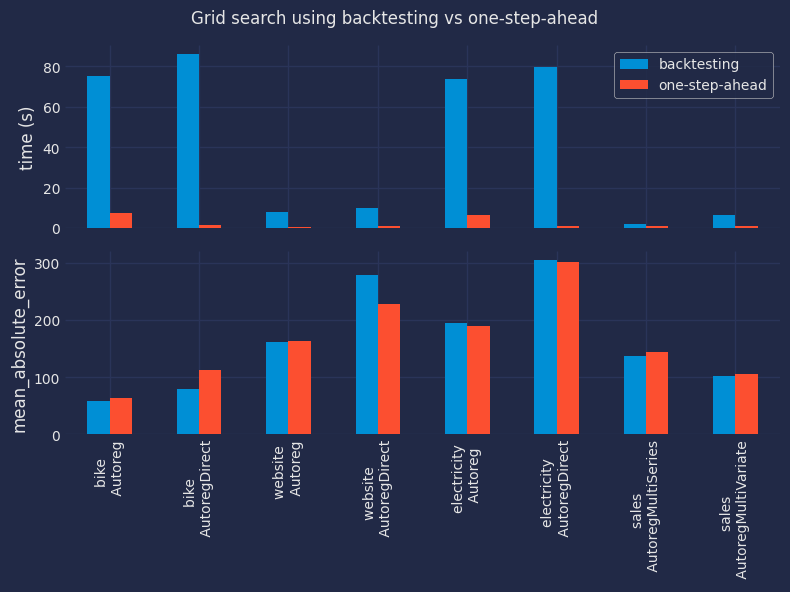

In [25]:
# Results
# ==============================================================================
summarize_results(
    results   = results_grid_search,
    metric    = metric,
    plot      = True,
    fig_size  = (8, 6),
    save_plot = "bayesian_search_results.png"
)

# Unit test

## _evaluate_grid_hyperparameters: backtesting vs one-step-ahead

In [26]:
from skforecast.model_selection.model_selection import _evaluate_grid_hyperparameters
from sklearn.model_selection import ParameterGrid

In [27]:
# Data
# ==============================================================================
data = fetch_dataset(
    name="h2o",
    raw=True,
    kwargs_read_csv={"names": ["y", "datetime"], "header": 0},
    verbose=False,
)
data["datetime"] = pd.to_datetime(data["datetime"], format="%Y-%m-%d")
data = data.set_index("datetime")
data = data.asfreq("MS")
data = data[["y"]]
data = data.sort_index()
end_train = "2001-01-01 23:59:00"
end_validation = "2006-01-01 23:59:00"
target = "y"
exog_features = None

In [28]:
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 10
            )
lags_grid = [3, 10, [1, 2, 3, 20]]
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3, 5]
}
param_grid = list(ParameterGrid(param_grid))

results_backtesting = _evaluate_grid_hyperparameters(
    forecaster         = forecaster,
    y                  = data.loc[:end_validation, target],
    exog               = data.loc[:end_validation, exog_features] if exog_features else None,
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = 1,
    method             = 'backtesting',
    refit              = False,
    metric             = ['mean_squared_error', 'mean_absolute_error'],
    initial_train_size = len(data.loc[:end_train]),
    fixed_train_size   = False,
    return_best        = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = False
)

results_one_step_ahead = _evaluate_grid_hyperparameters(
    forecaster         = forecaster,
    y                  = data.loc[:end_validation, target],
    exog               = data.loc[:end_validation, exog_features] if exog_features else None,
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    metric             = ['mean_squared_error', 'mean_absolute_error'],
    initial_train_size = len(data.loc[:end_train]),
    method             = 'one_step_ahead',
    return_best        = False,
    verbose            = False,
    show_progress      = False
)

assert results_backtesting.equals(results_one_step_ahead)

/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1244: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


## _calculate_metrics_multiseries vs _calculate_metrics_multiseries_one_step_ahead

In [29]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from skforecast.model_selection_multiseries.model_selection_multiseries import _calculate_metrics_multiseries_one_step_ahead
from skforecast.model_selection_multiseries.model_selection_multiseries import _calculate_metrics_multiseries
from skforecast.model_selection.model_selection import _create_backtesting_folds
from skforecast.metrics import add_y_train_argument
from skforecast.metrics import mean_absolute_scaled_error

In [30]:
# Data download
# ==============================================================================
data = fetch_dataset(name="items_sales")
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

items_sales
-----------
Simulated time series for the sales of 3 different items.
Simulated data.
Shape of the dataset: (1097, 3)


In [31]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = 'ordinal',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

X, y = forecaster.create_train_X_y(series=data)
X_train = X.loc[X.index <= end_train, :]
y_train = y.loc[y.index <= end_train]
X_test = X.loc[X.index > end_train, :]
y_test = y.loc[y.index > end_train]

forecaster.regressor.fit(X_train, y_train)
pred = forecaster.regressor.predict(X_test)

In [32]:
# Test results _calculate_metrics_multiseries_one_step_ahead and _calculate_metrics_multiseries
# ==============================================================================
# Metrics should be equal when using step=1 in backtesting

# Metrics with _calculate_metrics_multiseries_one_step_ahead
metrics = [mean_absolute_error, mean_absolute_percentage_error, mean_absolute_scaled_error]
metrics = [add_y_train_argument(metric) for metric in metrics]

if forecaster.encoding in ['ordinal', 'ordinal_category']:
    X_train_encoding = forecaster.encoder.inverse_transform(X_train[['_level_skforecast']]).ravel()
    X_test_encoding = forecaster.encoder.inverse_transform(X_test[['_level_skforecast']]).ravel()
elif forecaster.encoding == 'onehot':
    X_train_encoding = forecaster.encoder.inverse_transform(
                            X_train.loc[:, forecaster.encoding_mapping.keys()]
                        ).ravel()
    X_test_encoding = forecaster.encoder.inverse_transform(
                            X_test.loc[:, forecaster.encoding_mapping.keys()]
                        ).ravel()
X_train_encoding = pd.Series(X_train_encoding, index=X_train.index)
X_test_encoding = pd.Series(X_test_encoding, index=X_test.index)

metrics_one_step_ahead = _calculate_metrics_multiseries_one_step_ahead(
    y_true = y_test,
    y_pred = pred,
    y_pred_encoding = X_test_encoding,
    y_train = y_train,
    y_train_encoding = X_train_encoding,
    levels = ['item_1', 'item_2', 'item_3'],
    metrics = metrics,
    add_aggregated_metric = True
)

display(metrics_one_step_ahead)

# Metrics with _calculate_metrics_multiseries
folds = _create_backtesting_folds(
    data = data,
    window_size = 24,
    initial_train_size = len(data_train),
    test_size = 1,
    externally_fitted = False,
    refit = False,
    fixed_train_size = True,
    gap = 0,
    skip_folds = None,
    allow_incomplete_fold = True,
    return_all_indexes = False,
    differentiation = None,
    verbose = False
)
_, predictions = backtesting_forecaster_multiseries(
    series=data,
    forecaster=forecaster,
    steps=1,
    metric=metrics,
    initial_train_size = len(data_train),
    refit=False,
    add_aggregated_metric=True,
    show_progress=False
)
metrics_backtesting = _calculate_metrics_multiseries(
    series = data,
    predictions= predictions,
    folds= folds,
    span_index= data.index,
    window_size = 24,
    metrics= metrics,
    levels= ['item_1', 'item_2', 'item_3'],
    add_aggregated_metric = True
)

display(metrics_backtesting)

assert metrics_backtesting.equals(metrics_one_step_ahead)

,levels,mean_absolute_error,mean_absolute_percentage_error,mean_absolute_scaled_error
0,item_1,0.820748,0.040761,0.537711
1,item_2,2.330964,0.152464,0.989540
2,item_3,3.093253,0.207347,0.835301
3,average,2.081655,0.133524,0.787517
4,weighted_average,2.081655,0.133524,0.787517
5,pooling,2.081655,0.133524,0.823316


,levels,mean_absolute_error,mean_absolute_percentage_error,mean_absolute_scaled_error
0,item_1,0.820748,0.040761,0.537711
1,item_2,2.330964,0.152464,0.989540
2,item_3,3.093253,0.207347,0.835301
3,average,2.081655,0.133524,0.787517
4,weighted_average,2.081655,0.133524,0.787517
5,pooling,2.081655,0.133524,0.823316


## _evaluate_grid_hyperparameters_multiseries: backtesting vs one-step-ahead

In [33]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from skforecast.model_selection_multiseries.model_selection_multiseries import _evaluate_grid_hyperparameters_multiseries
from skforecast.metrics import mean_absolute_scaled_error

In [34]:
# Data download
# ==============================================================================
data = fetch_dataset(name="items_sales")
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()
exog_features = None

items_sales
-----------
Simulated time series for the sales of 3 different items.
Simulated data.
Shape of the dataset: (1097, 3)


In [35]:
forecaster = ForecasterAutoregMultiSeries(
    regressor          = LGBMRegressor(random_state=123, verbose=-1),
    lags               = 24,
    encoding           = 'ordinal',
    transformer_series = None,
    transformer_exog   = None,
    weight_func        = None,
    series_weights     = None,
    differentiation    = None,
    dropna_from_series = False,
    fit_kwargs         = None,
    forecaster_id      = None
)
lags_grid = [3, 10]
param_grid = {
    'n_estimators': [5, 10],
    'max_depth': [2, 3]
}
param_grid = list(ParameterGrid(param_grid))

results_backtesting = _evaluate_grid_hyperparameters_multiseries(
                            forecaster            = forecaster,
                            series                = data,
                            param_grid            = param_grid,
                            steps                 = 1,
                            metric                = metrics,
                            aggregate_metric      = ['weighted_average', 'average', 'pooling'],
                            initial_train_size    = len(data_train),
                            method                = 'backtesting',
                            fixed_train_size      = True,
                            gap                   = 0,
                            skip_folds            = None,
                            allow_incomplete_fold = True,
                            levels                = None,
                            exog                  = data.loc[:end_validation, exog_features] if exog_features else None,
                            lags_grid             = lags_grid,
                            refit                 = False,
                            n_jobs                = 'auto',
                            return_best           = False,
                            verbose               = False,
                            show_progress         = False,
                            suppress_warnings     = False
                        )

results_one_step_ahead = _evaluate_grid_hyperparameters_multiseries(
                            forecaster            = forecaster,
                            series                = data,
                            param_grid            = param_grid,
                            metric                = metrics,
                            initial_train_size    = len(data_train),
                            method                = 'one_step_ahead',
                            exog                  = data.loc[:data_train, exog_features] if exog_features else None,
                            lags_grid             = lags_grid,
                            return_best           = False,
                            verbose               = False,
                            show_progress         = False
                        )

assert results_backtesting.equals(results_one_step_ahead)


/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:1710: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(
